In [1]:
# Import necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np


In [2]:
# Load the cleaned dataset
data = pd.read_csv("Cleaned_data_set.csv")

# Save initial data size
print(f"Original Dataset Size: {len(data)}")

# Define features and target
X = data["Symptom Description"]
y = data["Potential Condition"]

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


Original Dataset Size: 1500


In [3]:
# Combine X and y into a single DataFrame
filtered_data = pd.DataFrame({"Symptom Description": X, "Potential Condition": y})

# Split into training and testing sets
train_data, test_data = train_test_split(filtered_data, test_size=0.15, random_state=42)

# Save the splits to CSV files for further processing
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print(f"\nData Split Complete:")
print(f"Training Data Size: {len(train_data)}")
print(f"Testing Data Size: {len(test_data)}")



Data Split Complete:
Training Data Size: 1275
Testing Data Size: 225


In [4]:
# Load BioBERT Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = BertForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1", num_labels=len(np.unique(y))
)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
class SymptomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the input text
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            add_special_tokens=True,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }


In [16]:
# Reload the training and testing data from saved CSVs
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# Define maximum sequence length and batch size
MAX_LEN = 128
BATCH_SIZE = 16

# Create datasets
train_dataset = SymptomDataset(
    train_data["Symptom Description"].tolist(), train_data["Potential Condition"], tokenizer, MAX_LEN
)
test_dataset = SymptomDataset(
    test_data["Symptom Description"].tolist(), test_data["Potential Condition"], tokenizer, MAX_LEN
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


D:\Amaan\New folder\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    for step, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            print(f"  Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")


Epoch 1/3
  Step 0/80 - Loss: 2.6995
  Step 10/80 - Loss: 2.6679
  Step 20/80 - Loss: 2.4892
  Step 30/80 - Loss: 2.7207
  Step 40/80 - Loss: 2.6024
  Step 50/80 - Loss: 2.5358
  Step 60/80 - Loss: 2.5128
  Step 70/80 - Loss: 2.7297
Epoch 1 completed. Average Loss: 2.6524
Epoch 2/3
  Step 0/80 - Loss: 2.7012
  Step 10/80 - Loss: 2.5362
  Step 20/80 - Loss: 2.6429
  Step 30/80 - Loss: 2.6435
  Step 40/80 - Loss: 2.8186
  Step 50/80 - Loss: 2.4965
  Step 60/80 - Loss: 2.6904
  Step 70/80 - Loss: 2.4594
Epoch 2 completed. Average Loss: 2.6351
Epoch 3/3
  Step 0/80 - Loss: 2.6999
  Step 10/80 - Loss: 2.4674
  Step 20/80 - Loss: 2.6290
  Step 30/80 - Loss: 2.3426
  Step 40/80 - Loss: 2.6089
  Step 50/80 - Loss: 2.6992
  Step 60/80 - Loss: 2.5037
  Step 70/80 - Loss: 2.6219
Epoch 3 completed. Average Loss: 2.6260


In [9]:
# Save the trained model and tokenizer
model.save_pretrained("biobert_model")
tokenizer.save_pretrained("biobert_tokenizer")


('biobert_tokenizer\\tokenizer_config.json',
 'biobert_tokenizer\\special_tokens_map.json',
 'biobert_tokenizer\\vocab.txt',
 'biobert_tokenizer\\added_tokens.json')

# Testing Bio-Bert model 


In [2]:
# Import necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the fine-tuned model and tokenizer
tokenizer = BertTokenizer.from_pretrained("biobert_tokenizer")
model = BertForSequenceClassification.from_pretrained("biobert_model")

# Set the model to evaluation mode
model.eval()

# Map predicted label to condition and remedy
condition_mapping = {
    0: ("Allergic Reaction", "Take antihistamines and avoid allergens."),
    1: ("Anxiety", "Practice deep breathing or consult a therapist."),
    2: ("Arthritis", "Apply a warm compress and take anti-inflammatory medications."),
    3: ("Asthma", "Use your inhaler and seek fresh air."),
    4: ("COVID-19", "Isolate, rest, and monitor symptoms. Consult a doctor if severe."),
    5: ("Common Cold", "Drink plenty of fluids and rest."),
    6: ("Diabetes", "Monitor your blood sugar levels and follow your prescribed treatment."),
    7: ("Flu", "Rest, stay hydrated, and take fever reducers."),
    8: ("Food Poisoning", "Stay hydrated and avoid solid foods until symptoms improve."),
    9: ("Gastroenteritis", "Drink oral rehydration solutions and rest."),
    10: ("Hypertension", "Reduce salt intake and practice relaxation techniques."),
    11: ("Kidney Stones", "Drink plenty of water and take prescribed pain relief."),
    12: ("Migraine", "Rest in a dark, quiet room and take prescribed medications."),
    13: ("Muscle Strain", "Apply ice, rest, and gently stretch the muscle."),
    14: ("Sinus Infection", "Use steam inhalation and drink warm fluids.")
}

# Function for manual symptom testing
def predict_condition():
    # Ask the user to input their symptoms
    symptom_description = input("Please describe your symptoms: ")
    
    # Tokenise the input
    inputs = tokenizer(
        symptom_description,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
    
    # Get the diagnosis and remedy
    diagnosis, remedy = condition_mapping.get(predicted_label, ("Unknown Condition", "Please consult a doctor for more information."))
    
    # Print the predicted diagnosis and remedy
    print(f"\nPredicted Condition: {diagnosis}")
    print(f"Suggested Action: {remedy}")

# Run the function
predict_condition()


Please describe your symptoms:  chills



Predicted Condition: Common Cold
Suggested Action: Drink plenty of fluids and rest.


# Additional feature added 

In [7]:
# Load the fine-tuned model and tokenizer
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("biobert_tokenizer")
model = BertForSequenceClassification.from_pretrained("biobert_model")

# Set the model to evaluation mode
model.eval()

# Map predicted label to condition and remedy
condition_mapping = {
    0: ("Allergic Reaction", "Take antihistamines and avoid allergens."),
    1: ("Anxiety", "Practice deep breathing or consult a therapist."),
    2: ("Arthritis", "Apply a warm compress and take anti-inflammatory medications."),
    3: ("Asthma", "Use your inhaler and seek fresh air."),
    4: ("COVID-19", "Isolate, rest, and monitor symptoms. Consult a doctor if severe."),
    5: ("Common Cold", "Drink plenty of fluids and rest."),
    6: ("Diabetes", "Monitor your blood sugar levels and follow your prescribed treatment."),
    7: ("Flu", "Rest, stay hydrated, and take fever reducers."),
    8: ("Food Poisoning", "Stay hydrated and avoid solid foods until symptoms improve."),
    9: ("Gastroenteritis", "Drink oral rehydration solutions and rest."),
    10: ("Hypertension", "Reduce salt intake and practice relaxation techniques."),
    11: ("Kidney Stones", "Drink plenty of water and take prescribed pain relief."),
    12: ("Migraine", "Rest in a dark, quiet room and take prescribed medications."),
    13: ("Muscle Strain", "Apply ice, rest, and gently stretch the muscle."),
    14: ("Sinus Infection", "Use steam inhalation and drink warm fluids."),
    15: ("Heart Attack", "Call emergency services immediately and chew aspirin if available."),
    16: ("Stroke", "Call emergency services immediately. Do not wait."),
    17: ("Severe Allergic Reaction", "Use an epinephrine auto-injector and call emergency services.")
}

# Ask the user to input their symptoms
symptom_description = input("Please describe your symptoms: ")

# Tokenise the input
inputs = tokenizer(
    symptom_description,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)

# Run inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

# Get the diagnosis and remedy
diagnosis, remedy = condition_mapping.get(predicted_label, ("Unknown Condition", "Please consult a doctor for more information."))

# Print the predicted diagnosis and remedy
print(f"\nPredicted diagnosis: {diagnosis}")
print(f"Suggested remedy: {remedy}")

# Additional check for emergency conditions
if predicted_label in [15, 16, 17]:  # Emergency conditions
    print("⚠️ Warning: Your symptoms indicate a medical emergency. Please seek immediate medical attention.")


Please describe your symptoms:  I have severe chest pain and difficulty breathing.



Predicted diagnosis: Common Cold
Suggested remedy: Drink plenty of fluids and rest.


# Model Evaluation and Reflection

In [14]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd

# Step 1: Load the fine-tuned model and tokenizer
tokenizer = BertTokenizer.from_pretrained("biobert_tokenizer")
model = BertForSequenceClassification.from_pretrained("biobert_model")
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 2: Define evaluation dataset for ambiguous, incomplete, and emergency inputs
evaluation_data = [
    {"input": "pain", "expected": "Unknown Condition"},
    {"input": "severe chest pain and sweating", "expected": "Heart Attack"},
    {"input": "difficulty breathing", "expected": "Asthma"},
    {"input": "headache", "expected": "Migraine"},
    {"input": "I feel unwell", "expected": "Unknown Condition"},
]

# Map predicted label to condition
condition_mapping = {
    0: "Allergic Reaction",
    1: "Anxiety",
    2: "Arthritis",
    3: "Asthma",
    4: "COVID-19",
    5: "Common Cold",
    6: "Diabetes",
    7: "Flu",
    8: "Food Poisoning",
    9: "Gastroenteritis",
    10: "Hypertension",
    11: "Kidney Stones",
    12: "Migraine",
    13: "Muscle Strain",
    14: "Sinus Infection",
    15: "Heart Attack",
    16: "Stroke",
    17: "Severe Allergic Reaction",
    "unknown": "Unknown Condition",
}

# Step 3: Define a function for testing predictions
def evaluate_model_on_input(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        confidence, predicted_label = torch.softmax(logits, dim=1).max(dim=1)
        predicted_condition = condition_mapping.get(
            predicted_label.item(), "Unknown Condition"
        )
    
    return predicted_condition, confidence.item()

# Step 4: Evaluate the model on the test cases
results = []
for case in evaluation_data:
    prediction, confidence = evaluate_model_on_input(case["input"])
    results.append({
        "Input": case["input"],
        "Expected": case["expected"],
        "Predicted": prediction,
        "Confidence": confidence,
        "Correct": prediction == case["expected"]
    })

# Convert results to a DataFrame for clarity
results_df = pd.DataFrame(results)
print(results_df)


                            Input           Expected    Predicted  Confidence  \
0                            pain  Unknown Condition  Common Cold    0.210000   
1  severe chest pain and sweating       Heart Attack  Common Cold    0.240320   
2            difficulty breathing             Asthma  Common Cold    0.219702   
3                        headache           Migraine  Common Cold    0.205116   
4                   I feel unwell  Unknown Condition  Common Cold    0.195772   

   Correct  
0    False  
1    False  
2    False  
3    False  
4    False  


Accuracy: 0.24

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        11
           5       0.24      1.00      0.39        54
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00        13
          11       0.00      0.00      0.00        12
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        19
          14       0.00      0.00      0.00        11

    accuracy                           0.24       225
   macro avg       0.02      0.07      0.

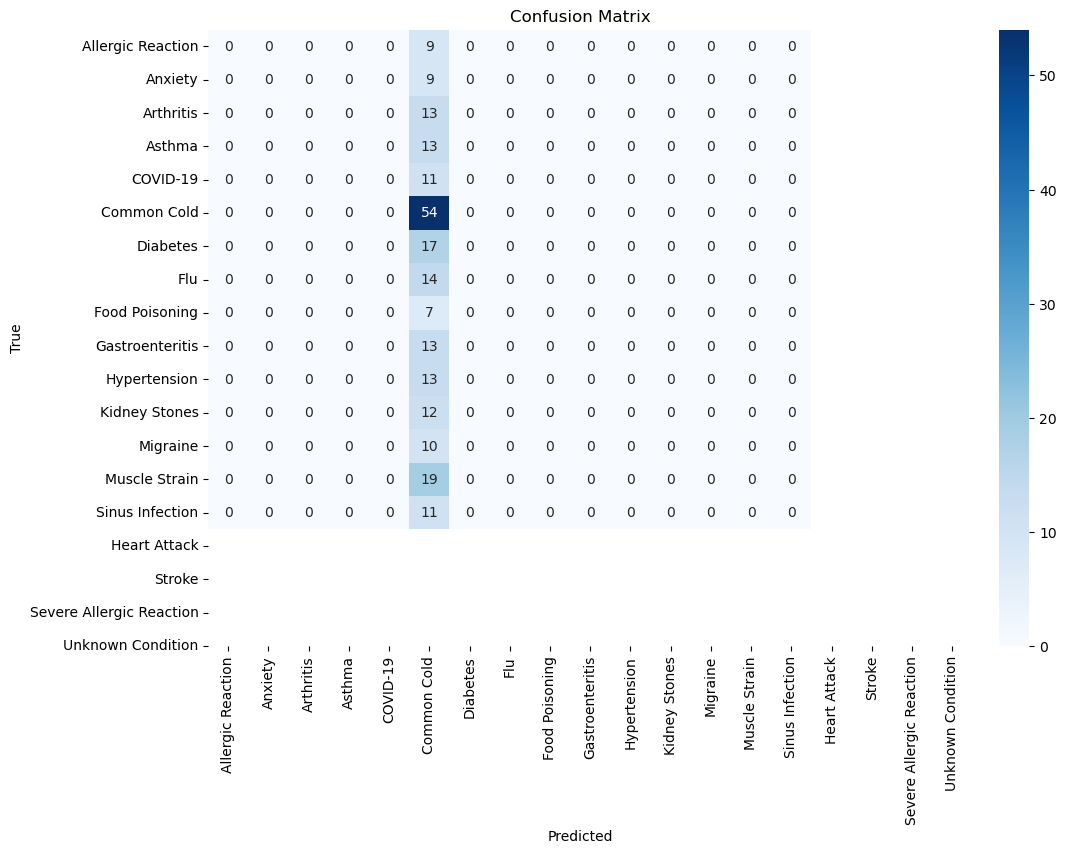

True Label Counts: Counter({5: 54, 13: 19, 6: 17, 7: 14, 2: 13, 3: 13, 10: 13, 9: 13, 11: 12, 14: 11, 4: 11, 12: 10, 0: 9, 1: 9, 8: 7})
Predicted Label Counts: Counter({5: 225})


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import torch

# Generate predictions on the test dataset
predictions, true_labels = [], []

# Ensure the model is in evaluation mode
model.eval()

# Run inference on the test dataset
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted labels and ground truth
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report with zero_division=0 to handle undefined metrics
print("\nClassification Report:")
print(classification_report(true_labels, predictions, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(condition_mapping.values()), 
            yticklabels=list(condition_mapping.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Count true and predicted labels
true_label_counts = Counter(true_labels)
predicted_label_counts = Counter(predictions)

# Print label-wise counts
print("True Label Counts:", true_label_counts)
print("Predicted Label Counts:", predicted_label_counts)

